# Trans-ethnic GWAS pipeline - Demo

## Aims

Create a modular trans-ethnic GWAS pipeline that can perform essential GWAS analysis with flexibility

## Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

## Download Plink

In [ ]:
%%bash
wget https://s3.amazonaws.com/plink2-assets/plink2_linux_x86_64_20211217.zip
unzip plink2_linux_x86_64_20211217.zip

## Download Demo directory

In [ ]:
%%bash
dx download -r "Demo/"

## Run GWAS using Plink

- Input:  vcf file, covariate file, phenotype file
- Output: GWAS Summary Statistics

The covariates can be adjusted by providing a covariate file along the the corresponding column names.

Multiple phenotypes can also be tested by providing a phenotype file.

Both files should have subject ID in the first column with header "IID".

In [31]:
def gwas(genotype,covar_file,pheno_file,covar_name,pheno_name):
    cmd = f"./plink2 --vcf {genotype} \
    --extract-if-info R2 '>'= 0.4 \
    --covar {covar_file} \
    --covar-name {covar_name} \
    --covar-variance-standardize \
    --glm hide-covar \
    --out gwas \
    --pheno {pheno_file} \
    --pheno-name {pheno_name}"
    os.system(cmd)

In [32]:
gwas("Demo/chr1.dose.vcf","Demo/gwas.cov","Demo/pheno.cov","r1agey,ragender,EV1","r1alzdeme")

In [33]:
with open("gwas.log",'r') as f:
    print(f.read())
    f.close()

PLINK v2.00a3LM 64-bit Intel (17 Dec 2021)
Options in effect:
  --covar Demo/gwas.cov
  --covar-name r1agey,ragender,EV1
  --covar-variance-standardize
  --extract-if-info R2 >= 0.4
  --glm hide-covar
  --out gwas
  --pheno Demo/pheno.cov
  --pheno-name r1alzdeme
  --vcf Demo/chr1.dose.vcf

Hostname: 3442f28beda6
Working directory: /opt/notebooks
Start time: Fri Jan 14 19:31:41 2022

Random number seed: 1642188701
3692 MiB RAM detected; reserving 1846 MiB for main workspace.
Using up to 2 compute threads.
--vcf: 3738242 variants scanned.
--vcf: gwas-temporary.pgen + gwas-temporary.pvar.zst + gwas-temporary.psam
written.
10 samples (0 females, 0 males, 10 ambiguous; 10 founders) loaded from
gwas-temporary.psam.
635842 out of 3738242 variants loaded from gwas-temporary.pvar.zst.
1 binary phenotype loaded (5 cases, 5 controls).
3 covariates loaded from Demo/gwas.cov.
--covar-variance-standardize: 3 covariates transformed.
Calculating allele frequencies... done.
635842 variants remaining a

## Manhattan Plot

- Input: GWAS summary statistics
- Output: Manhattan Figure

In [17]:
def manhattan(filename):

    df = pd.read_csv(filename, sep="\t")
    df.rename({"MARKERNAME":"SNP", "CHROMOSOME":"chromosome"}, axis="columns", inplace=True)
    df['minuslog10pvalue'] = -np.log10(df.Pvalue)
    df.chromosome = df.chromosome.astype('category')
    df = df.sort_values('chromosome')

    df['ind'] = range(len(df))
    df_grouped = df.groupby(('chromosome'))
    
    fig = plt.figure(figsize=(25, 14))
    font = {'family': 'serif','color': 'darkred','weight': 'normal','size': 20}
    ax = fig.add_subplot(111)
    colors = ['red','green','blue', 'yellow']
    x_labels = []
    x_labels_pos = []
    for num, (name, group) in enumerate(df_grouped):
        group.plot(kind='scatter', x='ind', y='minuslog10pvalue',color=colors[num % len(colors)], ax=ax)
        x_labels.append(name)
        x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))
    ax.set_xticks(x_labels_pos)
    ax.set_xticklabels(x_labels)
    ax.set_xlim([0, len(df)])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='out', bottom=True)
    ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='out', left=True)
    ax.set_ylabel("$log_{10}$ P", fontdict=font, labelpad=10)
    ax.set_xlabel("Chromosome", labelpad=10, fontdict=font)  
    plt.savefig("manhattan_prs.png")
    plt.show()

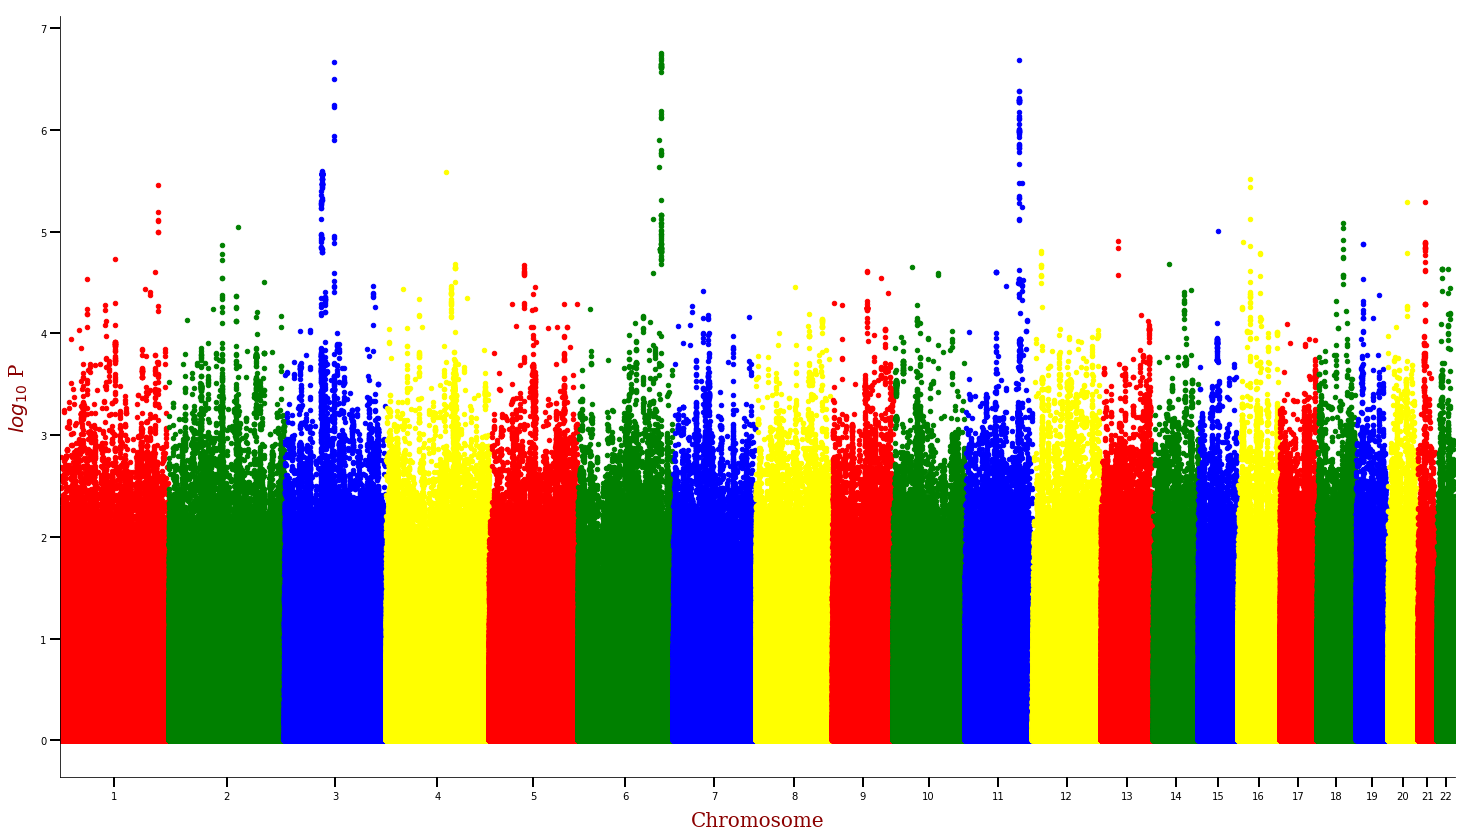

In [18]:
manhattan("SA_GWAS_summary_statistics.txt")

## Trans-ethnic analysis with MR-MEGA

### Download MR-MEGA

In [ ]:
%%bash
wget https://tools.gi.ut.ee/tools/MR-MEGA_v0.2.zip
unzip MR-MEGA_v0.2.zip -d MR-MEGA

### Compile MR-MEGA

In [ ]:
%%bash
cd MR-MEGA
make

### Create input file with desired summary statistics

Each GWAS study file has mandatory column headers:

1. MARKERNAME – snp name

2. EA – effect allele

3. NEA – non effect allele

4. OR - odds ratio

5. OR_95L - lower confidence interval of OR

6. OR_95U - upper confidence interval of OR

7. EAF – effect allele frequency

8. N - sample size

9. CHROMOSOME  - chromosome of marker

10. POSITION - position of marker

 

In case of quantitative trait:

- BETA – beta

- SE – std. error

In [ ]:
%%bash
echo "Demo/SA_GWAS_summary_statistics.txt" >> mrmega.in
echo "Demo/EA_GWAS_summary_statistics.txt" >> mrmega.in

### Run MR-MEGA

Use --qt command for BETA.

Use -o to customize output file name.

In [ ]:
%%bash
./MR-MEGA/MR-MEGA --qt -o transethnic

## Polygenic risk score calculation with PRSice v2

In [ ]:
%%bash
wget https://github.com/choishingwan/PRSice/releases/download/2.3.5/PRSice_linux.zip
unzip PRSice_linux.zip

Mandatory arguments for PRSice:
- --base - path to GWAS summary statistics
- --target - path to genotype data

Each GWAS study file has mandatory column headers that are matched to arguments used by PRSice:

- --snp – SNP name (both base and target file needs matching SNP name)

- --a1 – effect allele

- --a2 – non effect allele

- --beta or --or NOT BOTH

- -p - P-value

Additional useful arguments:
- --binary-target: T/F
- --prevalence

In [3]:
%%bash
Rscript PRSice.R --prsice PRSice_linux --base Demo/SA_GWAS_summary_statistics_prsice.txt --a1 EA --a2 NEA --beta --snp MARKERNAME -p Pvalue --extract Demo/PRSice.valid \
--binary-target T --prevalence 0.07 --target Demo/prsice_target 

Begin plotting
Current Rscript version = 2.3.3
Plotting Bar Plot
Plotting the high resolution plot


PRSice 2.3.5 (2021-09-20) 
https://github.com/choishingwan/PRSice
(C) 2016-2020 Shing Wan (Sam) Choi and Paul F. O'Reilly
GNU General Public License v3
If you use PRSice in any published work, please cite:
Choi SW, O'Reilly PF.
PRSice-2: Polygenic Risk Score Software for Biobank-Scale Data.
GigaScience 8, no. 7 (July 1, 2019)
2022-01-14 17:04:15
./PRSice_linux \
    --a1 EA \
    --a2 NEA \
    --bar-levels 0.001,0.05,0.1,0.2,0.3,0.4,0.5,1 \
    --base Demo/SA_GWAS_summary_statistics_prsice.txt \
    --beta  \
    --binary-target T \
    --clump-kb 250kb \
    --clump-p 1.000000 \
    --clump-r2 0.100000 \
    --extract Demo/PRSice.valid \
    --interval 5e-05 \
    --lower 5e-08 \
    --num-auto 22 \
    --out PRSice \
    --prevalence 0.07 \
    --pvalue Pvalue \
    --seed 3927312030 \
    --snp MARKERNAME \
    --stat BETA \
    --target Demo/prsice_target \
    --thread 1 \
    --upper 0.5

Initializing Genotype file: Demo/prsice_target (bed) 

Start processing SA_GWAS_summary_sta